In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)
original_data = np.random.normal(loc=100, scale=15, size=1000)

In [3]:
def create_bootstrap_sample(data):
    return np.random.choice(data,size=len(data),replace=True)

boot_sample = create_bootstrap_sample(original_data)

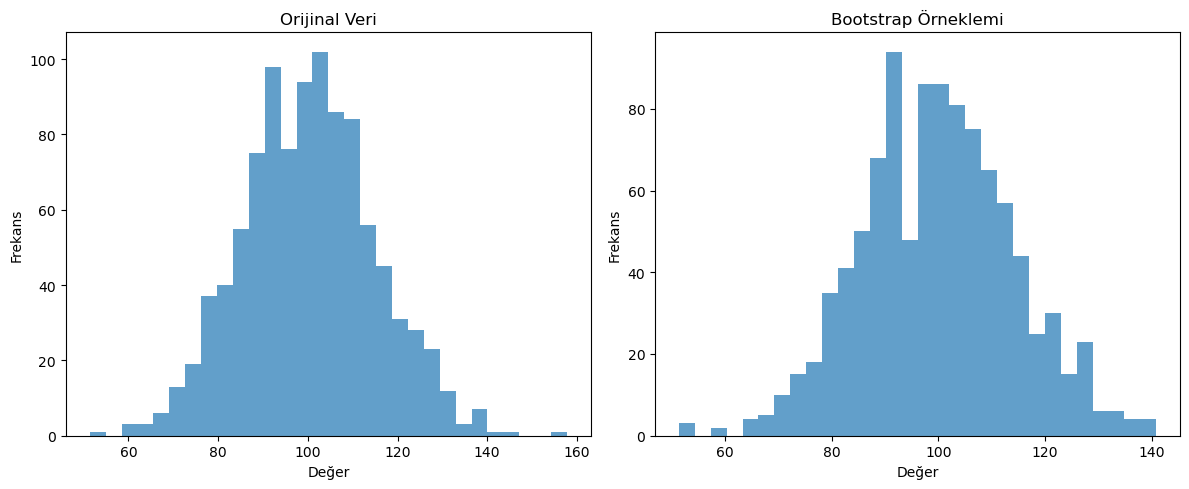

In [4]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(original_data, bins=30, alpha=0.7)
plt.title("Orijinal Veri")
plt.xlabel("Değer")
plt.ylabel("Frekans")

plt.subplot(1,2,2)
plt.hist(boot_sample, bins=30, alpha=0.7)
plt.title("Bootstrap Örneklemi")
plt.xlabel("Değer")
plt.ylabel("Frekans")

plt.tight_layout()
plt.show()

In [5]:
def bootstrap_mean_ci(data, n_bootstrap=1000, confidence=0.95):
    bootstrap_means = []

    for _ in range(n_bootstrap):
        # Bootstrap örneklemi oluştur
        boot_sample = create_bootstrap_sample(data)
        # Ortalamasını hesapla ve kaydet
        bootstrap_means.append(np.mean(boot_sample))

    # Güven aralığı sınırları
    ci_lower = np.percentile(bootstrap_means, (1-confidence)*100/2)
    ci_upper = np.percentile(bootstrap_means, (1+confidence)*100/2)

    return np.mean(data), ci_lower, ci_upper, bootstrap_means

# Ortalama için güven aralığını hesaplayalım
mean, ci_lower, ci_upper, boot_means = bootstrap_mean_ci(original_data)

print(f"Orijinal Verinin Ortalaması: {mean:.2f}")
print(f"Bootstrap %95 Güven Aralığı: ({ci_lower:.2f}, {ci_upper:.2f})")

Orijinal Verinin Ortalaması: 100.29
Bootstrap %95 Güven Aralığı: (99.41, 101.28)


In [6]:
# Farklı istatistikler için bootstrap
def bootstrap_statistics(data, n_bootstrap=1000):
    stats_dict = {
    "mean": [],
    "median": [],
    "std": [],
    "skewness": []
    }
    
    for _ in range(n_bootstrap):
        boot_sample = create_bootstrap_sample(data)
        stats_dict["mean"].append(np.mean(boot_sample))
        stats_dict["median"].append(np.median(boot_sample))
        stats_dict["std"].append(np.std(boot_sample))
        stats_dict["skewness"].append(np.std(boot_sample))
    
    return pd.DataFrame(stats_dict)

boot_stats = bootstrap_statistics(original_data)

print("\nBootstrap İstatistikleri")

for column in boot_stats.columns:
    print(f"\n{column.capitalize()}:")
    print(f"Ortalama: {boot_stats[column].mean():.2f}")
    print(f"Standart Hata: {boot_stats[column].std():.2f}")
    print(f"%95 Güven Aralığı: ({boot_stats[column].quantile(0.025):.2f}, {boot_stats[column].quantile(0.975):.2f})")


Bootstrap İstatistikleri

Mean:
Ortalama: 100.28
Standart Hata: 0.48
%95 Güven Aralığı: (99.33, 101.21)

Median:
Ortalama: 100.35
Standart Hata: 0.55
%95 Güven Aralığı: (99.27, 101.38)

Std:
Ortalama: 14.66
Standart Hata: 0.32
%95 Güven Aralığı: (14.03, 15.30)

Skewness:
Ortalama: 14.66
Standart Hata: 0.32
%95 Güven Aralığı: (14.03, 15.30)


In [7]:
# Gerçek veri örneği - Tips veri seti
tips = sns.load_dataset("tips")
tips


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [8]:
# Sigara içenler ve içmeyenler arasındaki farkı analiz edelim
# Gruplar arasındaki fark için bootstrap analiz yapar

def bootstrap_group_means(data, group_col, value_col, n_bootstrap=1000):
    groups = data[group_col].unique() 
    differences = []

    for _ in range(n_bootstrap):
        boot_sample = data.sample(n=len(data), replace=True)
        
        group_means = boot_sample.groupby(group_col)[value_col].mean()

        diff = group_means[groups[0]] - group_means[groups[1]]
        differences.append(diff)

    return differences

diff_means = bootstrap_group_means(tips, "smoker", "tip")

print("Sigara İçenler vs İçmeyenler Bahşiş Analizi")
print(f"Ortalama Fark: {np.mean(diff_means):.2f}")
print(f"%95 Güven Aralığı: ( {np.percentile(diff_means, 2.5):.2f}, {np.percentile(diff_means, 97.5):2f} )")

C:\Users\cansimsek\AppData\Local\Temp\ipykernel_11084\3649088643.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = boot_sample.groupby(group_col)[value_col].mean()


Sigara İçenler vs İçmeyenler Bahşiş Analizi
Ortalama Fark: -0.02
%95 Güven Aralığı: ( -0.41, 0.329315 )


Bootstrap konusunu günlük hayattan bir örnekle açıklayarak başlayalım.
### BÜYÜK RESİM - Neden Bootstrap?
Düşünün ki bir gölde balıkların ortalama boyunu ölçmek istiyorsunuz. Göldeki tüm balıkları yakalamak (tam popülasyon) mümkün değil. Bu durumda:

1. Gölden 100 balık yakalarsınız (örneklem)
2. Bu balıkların boylarını ölçersiniz
3. Ama bu 100 balık gerçekten popülasyonu temsil ediyor mu?

İşte Bootstrap burada devreye giriyor. Bootstrap der ki: "Madem popülasyona ulaşamıyoruz, elimizdeki örneklemi popülasyon gibi kullanıp, ondan yeni örneklemler oluşturalım."

### NEDEN TEKRARLI ÖRNEKLEME?

1.Belirsizliği Anlamak İçin:
 - Tek bir örneklem yanıltıcı olabilir
 - Çok sayıda örneklem alarak tahminimizin güvenilirliğini ölçebiliriz


2.Örnekleme Dağılımını Tahmin Etmek İçin:

 - Her örneklem biraz farklı sonuç verir
 - Bu farklılıkların dağılımını görmek önemlidir



### YERINE KOYARAK ÖRNEKLEME NEDEN ÖNEMLİ?
Düşünün ki elimizde 5 balık var: [20cm, 22cm, 25cm, 23cm, 21cm]

 - Yerine koymadan örnekleme yaparsak, hep aynı 5 balığı farklı sırada alırız
 - Yerine koyarak örnekleme yapınca:
     - [20cm, 20cm, 25cm, 21cm, 21cm] olabilir
     - [22cm, 23cm, 23cm, 25cm, 20cm] olabilir
     - Bu, popülasyondaki değişkenliği daha iyi yansıtır

BOOTSTRAP PARAMETRELERİ:

1. Örneklem Boyutu (n):

 - Genelde orijinal veri boyutu kadar alınır
 - Çok küçük olursa temsil gücü azalır
 - Çok büyük olursa hesaplama süresi artar


2. Tekrar Sayısı (n_bootstrap):

 - Genelde 1000 veya 10000 kullanılır
 - Az tekrar (örn. 100) güvenilirliği düşürür
 - Çok tekrar (örn. 100000) gereksiz hesaplama yükü getirir



### NE ZAMAN BOOTSTRAP KULLANMALIYIZ?

1. Popülasyona ulaşmak zor/imkansız ise
2. Verinin dağılımı hakkında varsayımlar yapmak istemiyorsak
3. Örneklem boyutu küçükse
4. Parametre tahminlerinin güvenilirliğini ölçmek istiyorsak

### ÖRNEKLEME İLE İLİŞKİSİ:
Bootstrap, aslında "örneklemden örnekleme" yaparak çalışır:

1. İlk örneklemi popülasyondan alırız (klasik örnekleme)
2. Sonraki örneklemleri bu ilk örneklemden alırız (bootstrap)
3. Bu sayede popülasyona tekrar tekrar gitmemize gerek kalmaz

Yukarıdaki kod örneğinde:

 - Gerçek popülasyonu simüle ettik (göldeki tüm balıklar)
 - İlk örneklemi aldık (100 balık)
 - Bu örneklemden 1000 bootstrap örneklemi oluşturduk
 - Sonuçları görselleştirdik

Bu görselleştirmede:

1. İlk grafik: İlk aldığımız 100 balıklık örneklem
2. Orta grafik: 1000 bootstrap örnekleminin ortalamalarının dağılımı
3. Son grafik: Gerçek popülasyon dağılımı

Bu şekilde:

 - Tek bir örneklemle (100 balık) başlayıp
 - Bootstrap ile 1000 farklı tahmin üreterek
 - Gerçek popülasyon ortalamasını tahmin edebildik

Bootstrap'ın gücü, elimizdeki sınırlı veriyi en iyi şekilde kullanarak popülasyon hakkında güvenilir tahminler yapabilmemizi sağlamasında yatar.

In [9]:
# Göldeki gerçek balık popülasyonunu simüle edelim
np.random.seed(42)
real_population = np.random.normal(25,5,10000)

# ilk örneklem
first_sample = np.random.choice(real_population,size=100)

def bootstrap_sample(data, n_bootstrap=1000):
    bootstrap_means = []

    for _ in range(n_bootstrap):
        new_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(new_sample))

    return bootstrap_means

# Bootstrap uygulama
bootstrap_results = bootstrap_sample(first_sample)

# Güven aralığı hesaplama
ci_lower = np.percentile(bootstrap_results,2.5)
ci_upper = np.percentile(bootstrap_results,97.5)

print(f"İlk örneklem ortalaması: {np.mean(first_sample):.2f} cm")
print(f"Bootstrap güven aralığı: ({ci_lower:.2f} cm, {ci_upper:.2f} cm)")
print(f"Gerçek popülasyon ortalaması: {np.mean(real_population):.2f} cm")

İlk örneklem ortalaması: 24.95 cm
Bootstrap güven aralığı: (23.96 cm, 25.92 cm)
Gerçek popülasyon ortalaması: 24.99 cm
